We start by interpolating the thermophysical properties of the solid:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
T = np.array([20, 100, 200, 300, 400]) + 273.15
k_s = np.array([147, 155, 159, 159, 155])
c = np.array([739, 755, 797, 838, 922])

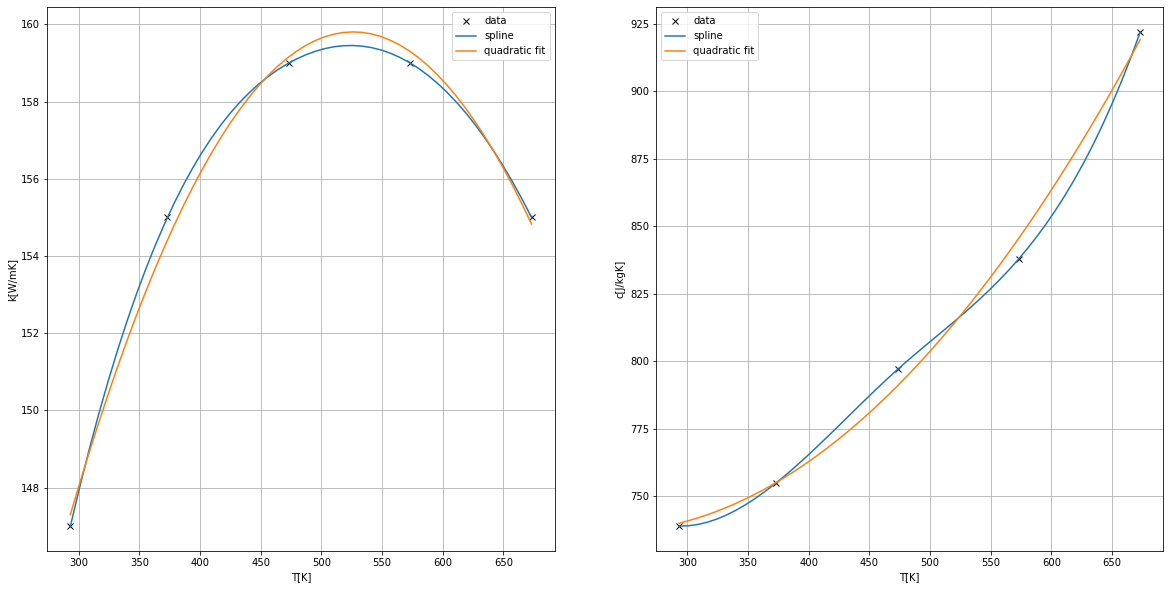

In [3]:
from scipy.optimize import curve_fit

T_range = np.linspace(20, 400) + 273.15

def func(x, a, b, c):
    return a + b*x + c*x**2

k_interpolate = scipy.interpolate.CubicSpline(T, k_s)
c_interpolate = scipy.interpolate.CubicSpline(T, c)

p_k, q_k = curve_fit(func, T, k_s)
p_c, q_c = curve_fit(func, T, c)

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

ax1.plot(T, k_s, 'kx', label = 'data')
ax1.plot(T_range, k_interpolate(T_range), label = 'spline')
ax1.plot(T_range, func(T_range, p_k[0], p_k[1], p_k[2]), label = 'quadratic fit')
ax1.set_xlabel('T[K]')
ax1.set_ylabel('k[W/mK]')
ax1.grid()
ax1.legend()

ax2.plot(T, c, 'kx', label = 'data')
ax2.plot(T_range, c_interpolate(T_range), label = 'spline')
ax2.plot(T_range, func(T_range, p_c[0], p_c[1], p_c[2]), label = 'quadratic fit')
ax2.set_xlabel('T[K]')
ax2.set_ylabel('c[J/kgK]')
ax2.grid()
ax2.legend()

Defining the geometry of the powderbed:

In [4]:
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(12345)

x = 1.54e-3
y = 0.7e-3
z = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x, y, z))

Set the default float type to float64


Defining the time and the domian:

In [5]:
t = 0.005

time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

Defining the other properties:

In [6]:
rho = 2650.0
A = 0.09
D = 70e-6
R = D/2
P = 250
v = 200e-3
T_0 = 273.15

Defining the top boundary neglecting the convection and radiation:

In [7]:
def top_bc(X):
    
    r_sq = (X[:,0] - x/4 - X[:,3]*v)**2 + (X[:,1] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*np.exp(-2*r_sq/R**2)

Plotting the end position of teh laser beam on the surface

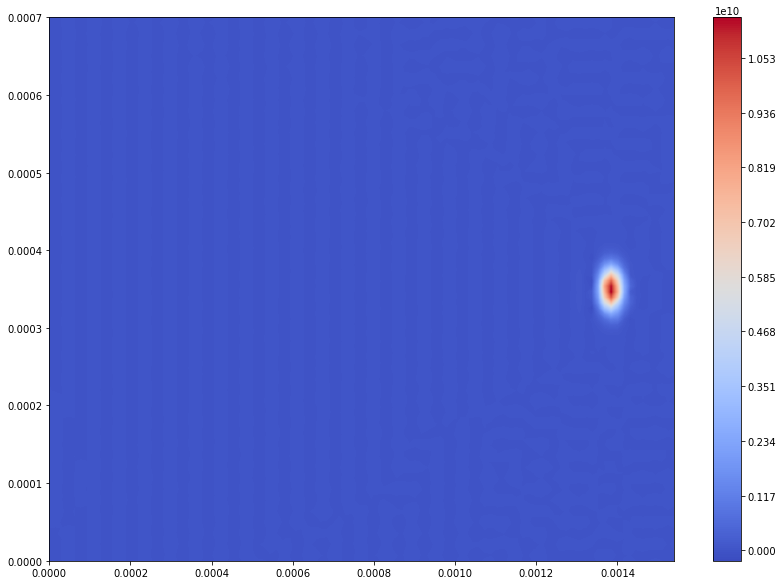

In [8]:
from scipy.interpolate import griddata

x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [0.005])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), top_bc(X), (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm)
plt.colorbar()

defining the pde system:

In [9]:
def pde_system(X, output):#
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
    
    k_eff = func(T, p_k[0], p_k[1], p_k[2])
    c_eff = func(T, p_c[0], p_c[1], p_c[2])
    
    #k_eff = 155
    #c_eff = 922
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = rho*c_eff*dT_dt - diff_T
    
    return f_T

def dummy(X, output):
    return output

Defining initial and boundary conditions:

In [10]:
def top_bc_new(X):
    
    r_sq = (X[:,0:1] - x/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y/2)**2
    
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)

ic = dde.icbc.IC(domain, lambda on_initial: 20 + T_0, lambda _, on_initial: on_initial)
#top = dde.icbc.NeumannBC(domain, top_bc(x), lambda on_boundary, x: on_boundary and np.isclose(x[2], z))
top = dde.icbc.RobinBC(domain, lambda X, y : top_bc_new(X)/func(y, p_k[0], p_k[1], p_k[2]), lambda x, on_boundary: on_boundary and np.isclose(x[2], z, atol=z/10))
sides = dde.icbc.DirichletBC(domain, lambda X : 20 + T_0, lambda x, on_boundary: on_boundary and not np.isclose(x[2], z, atol=z/10))

creating the dataset:

In [11]:
time = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time)

#setting training points at teh importtant part of the boundary
x_lin = np.linspace(0.1*x, 0.9*x, 10)
y_lin = np.linspace(1/3*y, 2/3*y, 10)
z_lin = np.linspace(0.9*z, z, 10)
t_lin = np.linspace(0, t, 10)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t_lin])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

data = dde.data.TimePDE(domain,
                        pde_system,
                       ic_bcs=[ic, top, sides],
                       num_domain=1000,
                       num_initial=1000,
                       num_boundary = 1000,
                       train_distribution="pseudo",
                       anchors=X)

In [12]:
#net = dde.nn.FNN([4] + [20] * 8 + [1], "sin", "Glorot normal")
net = dde.nn.MsFFN([4] + [60] * 4 + [1], "sin", "Glorot normal", sigmas = [1e-1, 1])

def feature_transform(X):
    return tf.concat(
        [X[:, 0:1]/x, 
         X[:, 1:2]/y,
         X[:, 2:3]/z,
        X[:, 3:4]/t], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = Temperature*1000 + 20 + T_0
    return T_new
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=0, display_every=1000)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/nils/anaconda3/envs/dde/lib/python3.9/site-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
2022-05-21 16:13:36.630050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 16:13:36.652731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 16:13:36.653087: I tensorflow/stream_execu

'compile' took 2.671832 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.72e+26, 4.23e+05, 2.82e+14, 6.57e+05]    [2.72e+26, 4.23e+05, 2.82e+14, 6.57e+05]    []  

Best model at step 0:
  train loss: 2.72e+26
  test loss: 2.72e+26
  test metric: []

'train' took 1.101562 s



In [13]:
weights = 1/np.array(losshistory.loss_train[0])
weights_2 = np.array([1, 1, 1, 1])
model.compile("adam", lr=1e-3, loss_weights=weights*weights_2)
resampler = dde.callbacks.PDEResidualResampler(100)
losshistory, train_state = model.train(epochs=2000, display_every=1000, callbacks=[resampler])

Compiling model...
'compile' took 2.072097 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.57e-02, 4.15e-01, 1.46e-01, 3.76e-01]    [9.57e-02, 4.15e-01, 1.46e-01, 3.76e-01]    []  
1000      [3.67e-04, 7.65e-05, 4.06e-02, 4.14e-04]    [3.85e-04, 7.65e-05, 4.06e-02, 4.14e-04]    []  
2000      [7.96e-04, 3.31e-03, 3.86e-02, 2.65e-03]    [7.81e-04, 3.31e-03, 3.86e-02, 2.65e-03]    []  

Best model at step 1000:
  train loss: 4.14e-02
  test loss: 4.14e-02
  test metric: []

'train' took 291.873120 s



In [20]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=2000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs = 1000, display_every=100)

Compiling model...
'compile' took 1.991971 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
2000      [8.20e-04, 3.31e-03, 3.86e-02, 2.65e-03]    [7.81e-04, 3.31e-03, 3.86e-02, 2.65e-03]    []  
2100      [8.52e-04, 4.65e-05, 3.71e-02, 3.03e-04]                                                    
2200      [1.42e-03, 6.15e-05, 3.33e-02, 3.68e-04]                                                    
2300      [2.33e-03, 9.02e-05, 2.65e-02, 1.71e-04]                                                    
2400      [2.82e-03, 9.00e-05, 1.84e-02, 1.73e-04]                                                    
2500      [2.62e-03, 6.94e-05, 1.21e-02, 1.20e-04]                                                    
2600      [2.53e-03, 6.78e-05, 8.28e-03, 1.00e-04]                                                    
2700      [2.48e-03, 3.96e-05, 5.44e-03, 8.96e-05]                                                    
2

In [29]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=1e-20, gtol=1e-20, maxiter=10000, maxfun=None, maxls=50)
model.compile('L-BFGS', loss_weights=weights)
losshistory, train_state = model.train(epochs = 1000, display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 2.592764 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
4079      [5.90e-05, 9.76e-07, 6.29e-05, 8.66e-07]    [2.63e-02, 9.76e-07, 6.29e-05, 8.66e-07]    []  
4100      [5.84e-05, 9.51e-07, 6.30e-05, 9.14e-07]                                                    
4200      [5.19e-05, 9.13e-07, 6.13e-05, 7.53e-07]                                                    
4300      [4.76e-05, 8.23e-07, 5.97e-05, 6.09e-07]                                                    
4400      [4.31e-05, 7.55e-07, 5.88e-05, 6.01e-07]                                                    
4500      [3.93e-05, 7.99e-07, 5.73e-05, 5.23e-07]                                                    
4600      [3.66e-05, 7.18e-07, 5.57e-05, 4.79e-07]                                                    
4700      [3.35e-05, 6.08e-07, 5.46e-05, 4.86e-07]                                                    
4

11800     [5.47e-06, 7.76e-06, 7.57e-06, 8.32e-08]                                                    
11900     [5.45e-06, 8.01e-06, 7.12e-06, 7.64e-08]                                                    
12000     [5.27e-06, 7.90e-06, 7.21e-06, 7.53e-08]                                                    
12100     [5.16e-06, 7.80e-06, 7.22e-06, 6.96e-08]                                                    
12200     [5.10e-06, 7.84e-06, 7.03e-06, 6.38e-08]                                                    
12300     [5.06e-06, 7.89e-06, 6.79e-06, 6.73e-08]                                                    
12400     [4.92e-06, 7.94e-06, 6.66e-06, 6.47e-08]                                                    
12500     [4.85e-06, 7.77e-06, 6.71e-06, 6.11e-08]                                                    
12600     [4.76e-06, 7.70e-06, 6.64e-06, 6.10e-08]                                                    
12700     [4.70e-06, 7.67e-06, 6.57e-06, 5.81e-08]                       

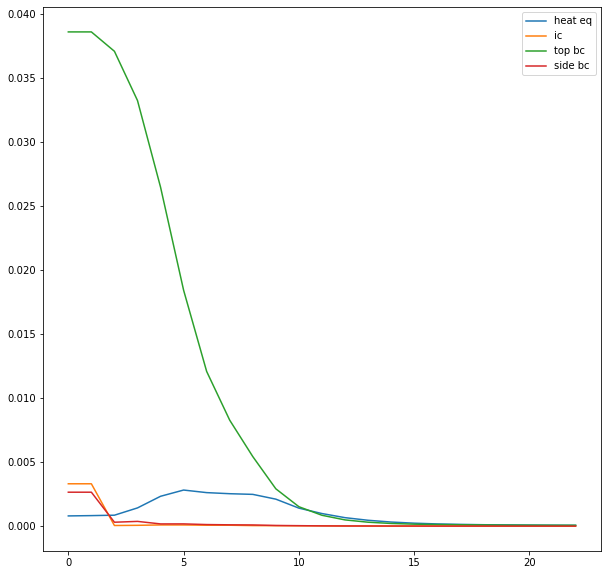

In [21]:
loss_names = ['heat eq', 'ic','top bc', 'side bc']
n = 3
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

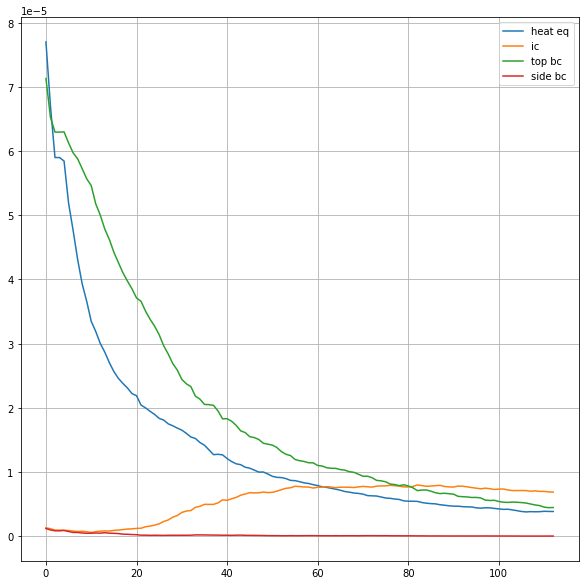

In [31]:
loss_names = ['heat eq', 'ic','top bc', 'side bc']
n = 23
plt.figure(figsize = (10, 10))

for loss, name in zip(np.array(losshistory.loss_train).T, loss_names):
    plt.plot(loss[n:], label = name)

plt.grid()
plt.legend()

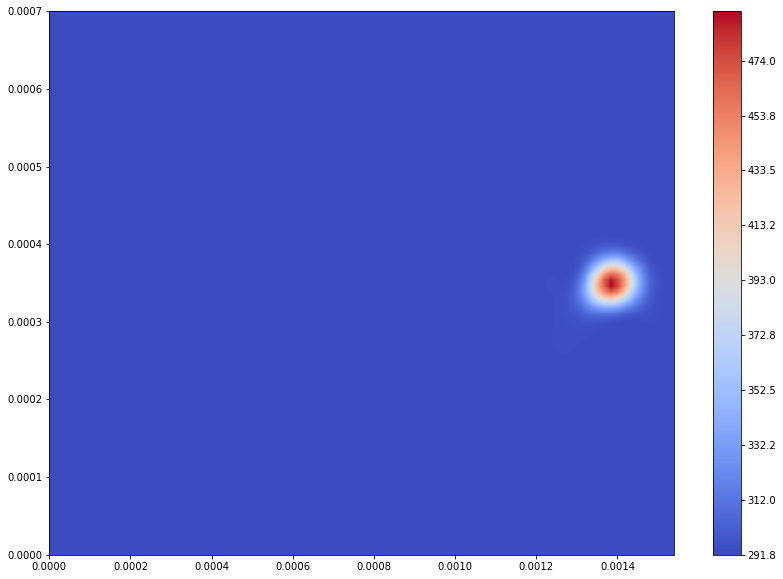

In [54]:
x_lin = np.linspace(0, x)
y_lin = np.linspace(0, y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 1000, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

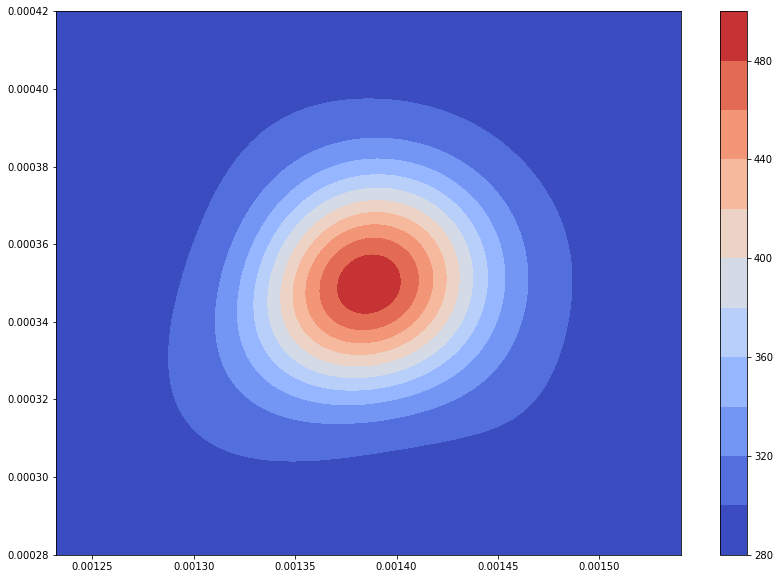

In [52]:
x_lin = np.linspace(0.8*x, x)
y_lin = np.linspace(0.4*y, 0.6*y)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z], [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
data = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, yi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

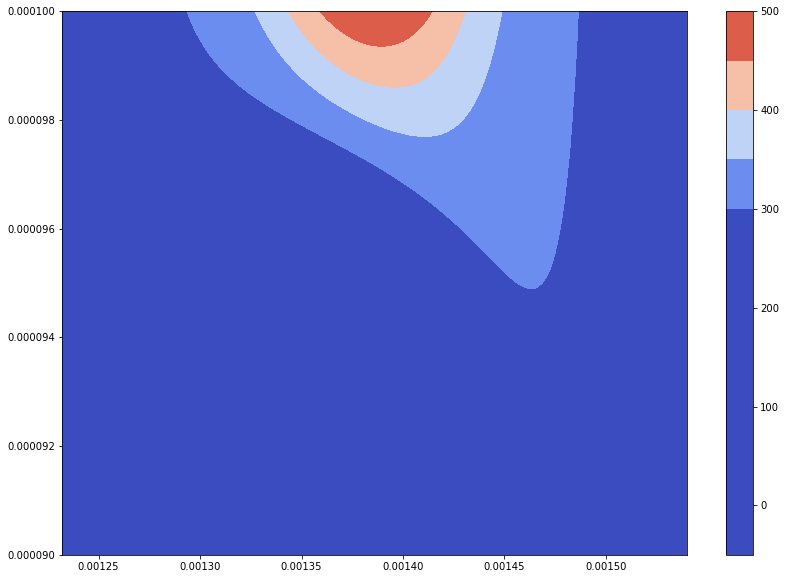

In [53]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0.9*z, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [ ]:
x_lin = np.linspace(0.8*x, x)
z_lin = np.linspace(0.9*z, z)
xx, yy, zz, tt = np.meshgrid(x_lin, [y/2], z_lin, [t])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
zi = np.linspace(zz.min(), zz.max(), 100)
data = griddata((np.ravel(xx), np.ravel(zz)), Y[:,0], (xi[None,:], zi[:,None]), method='cubic')

plt.figure(figsize = (14, 10))
plt.contourf(xi, zi, data, 10, cmap=plt.cm.coolwarm, vmin = 273.15 + 20)
plt.colorbar()

In [55]:
data.min()

291.7534055601742

In [58]:
model.save('test/')

INFO:tensorflow:test/-14809.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'test/-14809.ckpt'